In [ ]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install numpy==1.15.4 --user
# !{sys.executable} -m pip install keras==2.1.3 --user
# !{sys.executable} -m pip install pandas==0.23.4 --user
# !{sys.executable} -m pip install scikit-image==0.14.1 --user
# !{sys.executable} -m pip install scikit-learn==0.19.0 --user
# !{sys.executable} -m pip install tensorflow --user



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import keras
import skimage
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert keras.__version__ == '2.1.3'
assert skimage.__version__ == '0.14.1'
assert sklearn.__version__ == '0.19.2'
assert tensorflow.__version__ == '1.12.0'


Using TensorFlow backend.


In [2]:
# Load all images

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                  for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f, as_gray=True))
    
    return images

images = load_data('../data/train/cropped')
print(len(images))

467


In [3]:
# Explore shapes
for image in images[:3]:
    print('image.shape[before]', image.shape)

image.shape[before] (24, 17)
image.shape[before] (60, 45)
image.shape[before] (148, 95)


In [6]:
# Transform all images to 250x250

import skimage.transform
image_size = 64
images_transformed = [skimage.transform.resize(image, (image_size, image_size)) for image in images]

# Confirm transformation shape
for image in images_transformed[:3]:
    print('image.shape[after]', image.shape)
    

image.shape[after] (64, 64)
image.shape[after] (64, 64)
image.shape[after] (64, 64)


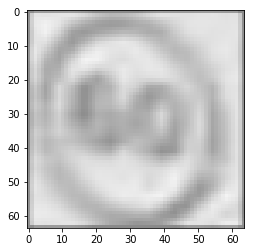

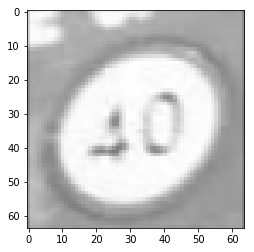

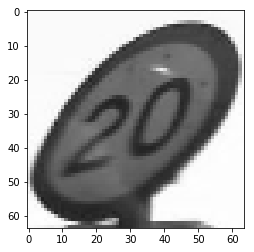

In [7]:
from PIL import Image

for image in images_transformed[:3]:
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    plt.figure()
    plt.imshow(im)
    plt.show()



In [8]:
# Load Labels 
data = pd.read_csv("../data/train.csv")
data = data.sort_values("Img_Name").reset_index(drop=True)
labels = data["Label"]

labels.head()

0    Speed Limit 60
1    Speed Limit 40
2    Speed Limit 20
3    Speed Limit 40
4    Speed Limit 50
Name: Label, dtype: object

In [9]:
# Categorize labels..

import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = np.array(labels)
X = np.array(images_transformed)
X = X[:, :, :, np.newaxis]   # (250,250) --> (467,250,250,1)

num_categories = 6
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y)
y_labels_categorized = to_categorical(y_labels_encoded, num_categories)

print('len(X)', len(X))
print('len(y)', len(y))
print('len(y_labels_categorized)', len(y_labels_categorized))

len(X) 467
len(y) 467
len(y_labels_categorized) 467


In [11]:
# 80/20 Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y_labels_categorized, test_size=0.2, random_state=42)

In [12]:
# BASELINE MODEL -- Feedforward network

model = Sequential()
model.add(Flatten(input_shape=(image_size,image_size,1)))
model.add(Dense(units=image_size,activation="relu"))
model.add(Dense(units=image_size,activation="relu"))
model.add(Dense(units=6,activation="softmax"))
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [22]:
%time model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

CPU times: user 5.54 s, sys: 1.26 s, total: 6.79 s
Wall time: 2.22 s


In [23]:
accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32)
accuracy

94/94 [==============================] - 0s 163us/step


[1.7168894853997738, 0.5744680927154866]

In [41]:
# FINAL MODEL -- Convolutional NN with Pooling and Dropout

total_epochs_trained = 0
epoch_acc = []
epoch_loss = []

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(image_size,image_size,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', #opt
              metrics=['accuracy']) 

# NOTE: If loss=categorical_crossentropy, 
# then 'accuracy' metrics == categorical_accruacy

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 60, 60, 32)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)             0         
__________

In [42]:
# data_gen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=False,
#     fill_mode="nearest",
#     channel_shift_range=0.3,
# )


# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# data_gen.fit(X_train)

# # fits the model on batches with real-time data augmentation:
# # model.fit_generator(train_gen.flow(X_train, y_train, batch_size=32),
# #                     steps_per_epoch=len(X_train) / 32, epochs=20)

# import os
# os.makedirs('../data/image_data_gen')

# i = 0
# for X_batch, y_batch in data_gen.flow(X_train, y_train, batch_size=5, save_to_dir='../data/image_data_gen', save_prefix='aug', save_format='jpg'):
#     i += 1
#     if i == 500:
#         break

# print("done.")

In [43]:
# Data augmentation on training set

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest",
    channel_shift_range=0.3,
)


train_gen.fit(X_train)


In [45]:
# Fit CNN model and track loss/acc over each epoch

epochs_per_round = 1
print("ACCURACY AFTER X EPOCHS:\n")
for i in range(150):
    # Fits the model on batches with real-time data augmentation:
    model.fit_generator(
        train_gen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) / 32, 
        epochs=epochs_per_round,
        verbose=0
    )
    
    total_epochs_trained += epochs_per_round

    test_acc = model.evaluate(x=X_test,y=y_test,batch_size=32, verbose=0)
    train_acc = model.evaluate(x=X_train,y=y_train,batch_size=32, verbose=0)
    print("EPOCH #", total_epochs_trained, "(loss, acc):", (round(test_acc[0],3), round(test_acc[1],3)))
    epoch_acc.append((test_acc[1], train_acc[1], total_epochs_trained))
    epoch_loss.append((test_acc[0], train_acc[0], total_epochs_trained))

    
print('done.')

ACCURACY AFTER X EPOCHS:

EPOCH # 51 (loss, acc): (1.331, 0.596)
EPOCH # 52 (loss, acc): (1.296, 0.574)
EPOCH # 53 (loss, acc): (1.301, 0.628)
EPOCH # 54 (loss, acc): (1.317, 0.543)
EPOCH # 55 (loss, acc): (1.308, 0.574)
EPOCH # 56 (loss, acc): (1.279, 0.606)
EPOCH # 57 (loss, acc): (1.293, 0.585)
EPOCH # 58 (loss, acc): (1.24, 0.574)
EPOCH # 59 (loss, acc): (1.192, 0.617)
EPOCH # 60 (loss, acc): (1.177, 0.585)
EPOCH # 61 (loss, acc): (1.142, 0.638)
EPOCH # 62 (loss, acc): (1.166, 0.617)
EPOCH # 63 (loss, acc): (1.227, 0.564)
EPOCH # 64 (loss, acc): (1.24, 0.585)
EPOCH # 65 (loss, acc): (1.145, 0.606)
EPOCH # 66 (loss, acc): (1.119, 0.617)
EPOCH # 67 (loss, acc): (1.148, 0.617)
EPOCH # 68 (loss, acc): (1.088, 0.681)
EPOCH # 69 (loss, acc): (1.187, 0.617)
EPOCH # 70 (loss, acc): (1.12, 0.649)
EPOCH # 71 (loss, acc): (1.045, 0.638)
EPOCH # 72 (loss, acc): (1.059, 0.628)
EPOCH # 73 (loss, acc): (1.079, 0.649)
EPOCH # 74 (loss, acc): (1.054, 0.649)
EPOCH # 75 (loss, acc): (1.059, 0.649)
EP

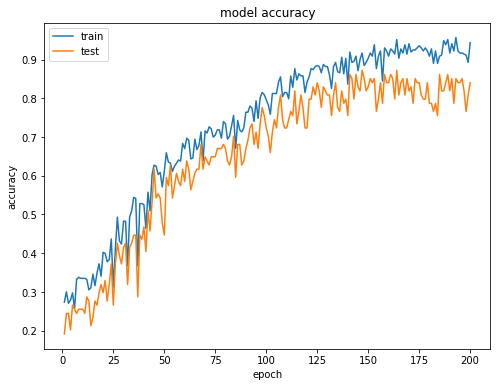

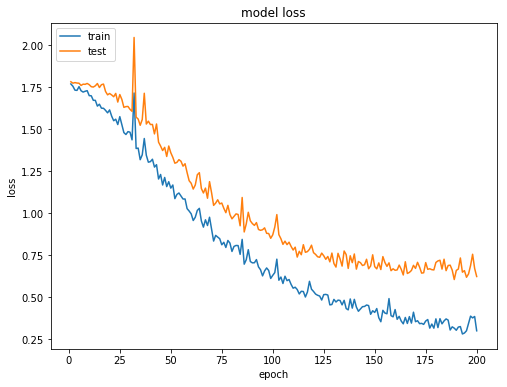

In [53]:
# Visualize accuracy on train/test set over time
test_acc, train_acc, total_epochs_trained = zip(*epoch_acc)

plt.figure(figsize=(8, 6))
plt.plot(total_epochs_trained, train_acc)
plt.plot(total_epochs_trained, test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualize loss on train/test set over time
test_loss, train_loss, total_epochs_trained = zip(*epoch_loss)

plt.figure(figsize=(8, 6))
plt.plot(total_epochs_trained, train_loss)
plt.plot(total_epochs_trained, test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32,verbose=0)
print("Accuracy:", round(accuracy[1],4))
print("Loss:", round(accuracy[0],4))

Accuracy: 0.8404
Loss: 0.6218


In [56]:
predictions = model.predict(X_test)
print('First prediction:', predictions[0])

predict_max = [max(class_probs) for class_probs in predictions]
print('Average predicted class probability:', np.mean(predict_max))

correct = [1 if np.argmax(predictions[i])==np.argmax(y_test[i]) else 0 for i in range(len(y_test))]
print("%-correct: ", np.mean(correct))


First prediction: [0.02810316 0.09088899 0.06399721 0.47800362 0.15545255 0.1835544 ]
Average predicted class probability: 0.77769387
%-correct:  0.8404255319148937
